In [1]:
# Import libraries and metrics
import warnings
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sktime.forecasting.all import EnsembleForecaster
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.structural import UnobservedComponents
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.series.detrend import ConditionalDeseasonalizer
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor)
from sktime.forecasting.all import (
    mean_absolute_percentage_error as mape,
    mean_absolute_scaled_error as mase,
    mean_squared_percentage_error as mspe,
    mean_squared_error as mse,
    #mean_squared_log_error as msle, # Doesn't exist
    ForecastingHorizon,
    NaiveForecaster
)

#from sktime.forecasting.naive import NaiveForecaster
#from sktime.forecasting.base import ForecastingHorizon

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 220)

****************** 0 - cases ******************
Tested period: 5
Tested period: 6
Tested period: 7
Tested period: 8
Tested period: 9
Tested period: 10
Tested period: 11
Tested period: 12
Tested period: 13
Tested period: 14
Tested period: 15
Tested period: 16
Tested period: 17
Tested period: 18
Tested period: 19
Tested period: 20
Tested period: 21
Tested period: 22
Tested period: 23
Tested period: 24
Tested period: 25
Tested period: 26
Tested period: 27
Tested period: 28
Tested period: 29
Tested test_size: 5
Tested period: 5
Tested period: 6
Tested period: 7
Tested period: 8
Tested period: 9
Tested period: 10
Tested period: 11
Tested period: 12
Tested period: 13
Tested period: 14
Tested period: 15
Tested period: 16
Tested period: 17
Tested period: 18
Tested period: 19
Tested period: 20
Tested period: 21
Tested period: 22
Tested period: 23
Tested period: 24
Tested period: 25
Tested period: 26
Tested period: 27
Tested period: 28
Tested period: 29
Tested test_size: 6
Tested period: 5
Teste

# Variables

In [2]:
def get_date_index(df_):
    year_list = df_["year"].tolist()
    week_list = df_["epi_week"].tolist()
    args_ = [(int(year_list[i]), int(week_list[i]), 1) for i in range(len(df_))]
    date_index = [pd.Timestamp.fromisocalendar(*args_[i]) for i in range(len(df_))]
    return date_index

In [3]:
df_epi_mc = pd.read_csv("df_covid19.csv")
df_epi_mc = df_epi_mc[df_epi_mc["epi_week"] != 53]
df_epi_mc.index = get_date_index(df_ = df_epi_mc)

df_epi_mc = df_epi_mc[((df_epi_mc["region"] == "Bogota") & (df_epi_mc["date"] <= "2021-10-01"))][["cases", "deaths"]].fillna(0)
df_epi_mc

,cases,deaths
2020-03-02,1,0
2020-03-09,1,0
2020-03-09,1,0
2020-03-09,5,0
2020-03-09,5,0
...,...,...
2021-09-27,149,5
2021-09-27,167,0
2021-09-27,207,5
2021-09-27,134,2


In [4]:
period_ = "1W"

df_epi_mc = pd.read_csv("df_covid19.csv")
df_epi_mc = df_epi_mc[df_epi_mc["epi_week"] != 53]
df_epi_mc.index = get_date_index(df_ = df_epi_mc)

df_epi_mc = df_epi_mc[((df_epi_mc["region"] == "Bogota") & (df_epi_mc["date"] <= "2021-06-01"))][["cases", "deaths"]].fillna(0)
df_epi_mc = df_epi_mc.astype(int).resample(period_).sum()

df_epi_mc

#period_ = "1W"
#df_epi_mc = pd.read_csv("df_epi_mc.csv").drop(columns = "Unnamed: 0", low_memory = False)
#df_epi_mc.index = get_date_index(df_ = df_epi_mc)
#del [df_epi_mc["year"], df_epi_mc["epi_week"]]
#df_epi_mc
#df_epi_mc[df_epi_mc["admin_name1"] == "Bogota"][["admin_name3", "industry_name", "merchant_postal_code"]].value_counts(dropna = False).reset_index()

#df_epi_mc = df_epi_mc[
#    (
#        (df_epi_mc["admin_name1"] == "Bogota") &
#        (df_epi_mc["industry_name"] == "Retail") &
#        (df_epi_mc["admin_name3"] == "Chapinero") &
#        (df_epi_mc["merchant_postal_code"] == "110231")
#    )
#].fillna(0)
#df_epi_mc

,cases,deaths
2020-03-08,1,0
2020-03-15,25,0
2020-03-22,123,0
2020-03-29,410,6
2020-04-05,612,24
2020-04-12,494,29
2020-04-19,554,21
2020-04-26,691,21
2020-05-03,831,32
2020-05-10,1078,29


# Estimar Periodo 

Introducir mas forecaster

In [5]:
def forecasting_model(df_, vars_, freq_, periods_range, test_size_range):
    df_params = []
    
    for n_var_, var_ in enumerate(vars_):
        print("****************** {} - {} ******************".format(n_var_, var_))
        
        y_ = df_[var_].copy()
        y_.index = pd.PeriodIndex(pd.date_range(y_.index[0], periods = len(y_.index), freq = freq_))
        
        for test_size in test_size_range:
            y_train, y_test = temporal_train_test_split(y_, test_size = test_size)
            fh = ForecastingHorizon(y_test.index, is_relative = False)
            
            for period in periods_range:
                # Forecasters
                forecaster = UnobservedComponents(level = "local linear trend", freq_seasonal = [{"period": period}])
                forecaster.fit(y_train)
                y_pred = forecaster.predict(fh)
            
                df_metrics = pd.DataFrame(
                    {
                        "variable" : [var_],
                        "period" : [period],
                        "test_size" : [test_size],
                        "RMSE" : [np.sqrt(mse(y_test, y_pred))],
                        "MAPE" : [mape(y_test, y_pred, symmetric = False)],
                        "MASE" : [mase(y_test, y_pred, y_train = y_train)]
                    }
                )
                df_params.append(df_metrics)
                print("Tested period: {}".format(period))
            print("Tested test_size: {}".format(test_size))
    
    df_params = pd.concat(df_params)
    
    return df_params

In [6]:
df_params_ = forecasting_model(df_ = df_epi_mc, vars_ = ["cases", "deaths"], freq_ = "W", periods_range = range(5, 30), test_size_range = range(5, 21))
df_params_

,variable,period,test_size,RMSE,MAPE,MASE
0,cases,5,5,15773.131947,0.351095,3.315861
0,cases,6,5,16191.972805,0.356217,3.369922
0,cases,7,5,16153.542157,0.361495,3.493111
0,cases,8,5,15851.085886,0.361274,3.481927
0,cases,9,5,15876.899427,0.355677,3.401593
...,...,...,...,...,...,...
0,deaths,25,20,338.460613,0.599306,4.174091
0,deaths,26,20,313.047605,0.984401,4.578126
0,deaths,27,20,375.514796,1.452905,5.422763
0,deaths,28,20,402.771769,1.635015,5.765139


In [7]:
df_cases = df_params_[df_params_["variable"] == "cases"]
df_cases[df_cases["RMSE"] == df_cases["RMSE"].min()]

,variable,period,test_size,RMSE,MAPE,MASE
0,cases,13,7,10486.208399,0.19227,2.012172


In [8]:
df_deaths = df_params_[df_params_["variable"] == "deaths"]
df_deaths[df_deaths["RMSE"] == df_deaths["RMSE"].min()]

,variable,period,test_size,RMSE,MAPE,MASE
0,deaths,17,5,124.665589,0.178941,1.615183


# Pruebas

In [9]:
test_size = 5

In [10]:
%%time
vars_ = ["cases", "deaths"]
df_params = pd.DataFrame({})

for values_ in vars_:
    print(f'****************** {values_} ******************')
    
    y_ = df_epi_mc[values_].copy()
    y_.index = pd.PeriodIndex(pd.date_range(y_.index[0], periods = len(y_.index), freq = period_))
    y_train, y_test = temporal_train_test_split(y_, test_size = test_size)
    
    fh = ForecastingHorizon(y_test.index, is_relative = False)
    
    error = {}
    mean_error = []
    for period in range(5, 15):
        print("Testing: " + str(period))
        forecaster = UnobservedComponents(level = "local linear trend", freq_seasonal = [{"period": period}])
        forecaster.fit(y_train)
        y_pred = forecaster.predict(fh)
        error[mse(y_pred, y_test)] = period
        mean_error.append(mse(y_pred, y_test))
    
    df_params[values_] = [error[min(mean_error)]]
    print(values_, error[min(mean_error)])
    forecaster = UnobservedComponents(level = "local linear trend", freq_seasonal = [{"period": error[min(mean_error)]}])
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    
df_params.to_csv('./prophet_params_out_periodo.csv')

In [11]:
df_params

,cases,deaths
0,13,6


# Estimar test size

In [12]:
%%time
vars_ = ["cases", "deaths"]
periodo_col = [3, 3]
df_params = pd.DataFrame({})
for n_values, values_ in enumerate(vars_):
    print(f'****************** {values_, n_values} ******************')
    y_ = df_epi_mc[values_].copy()
    period = periodo_col[n_values]
    y_.index = pd.PeriodIndex(pd.date_range(y_.index[0], periods = len(y_.index), freq = "W"))

    for test_size in range(7, 18):
        y_train, y_test = temporal_train_test_split(y_, test_size = test_size)
        fh = ForecastingHorizon(y_test.index, is_relative = False)

        error = {}
        mean_error = []
    
        print("Testing: " + str(test_size))
        forecaster = UnobservedComponents(level = "local linear trend", freq_seasonal = [{"period": period}])
        forecaster.fit(y_train)
        y_pred = forecaster.predict(fh)
        error[mape(y_pred, y_test)] = test_size
        mean_error.append(mape(y_pred, y_test))
    
    df_params[values_] = [error[min(mean_error)]]
    print(values_, error[min(mean_error)])
    forecaster = UnobservedComponents(level = "local linear trend", freq_seasonal = [{"period": error[min(mean_error)]}])
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)

df_params.to_csv('./prophet_params_out_test_size.csv')

In [13]:
df_params

,cases,deaths
0,17,17


# EPIMC

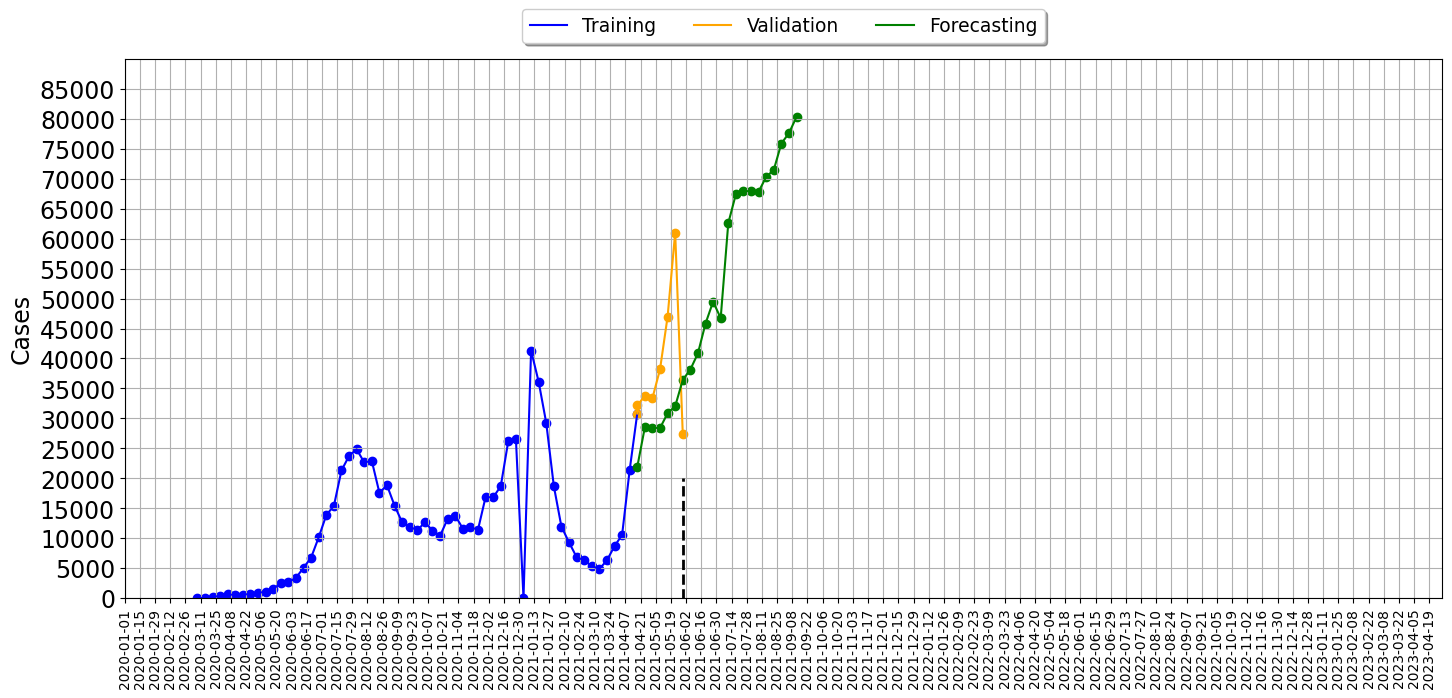

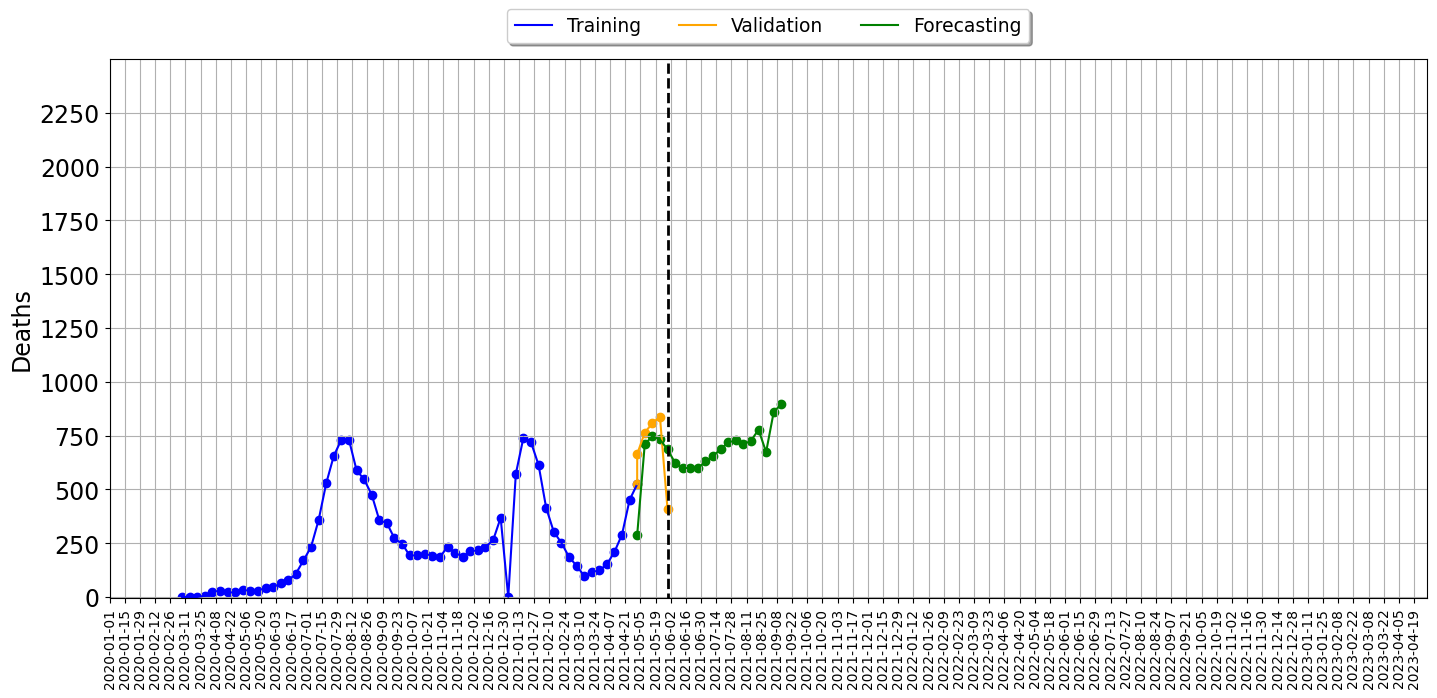

In [14]:
pred_size = 15
periodo_col = [13, 17]

vars_ = ["cases", "deaths"]
dict_indicador = {"cases" : "Cases", "deaths" : "Deaths"}
dict_test_size = {"cases" : 7, "deaths" : 5}

for n_values, values_ in enumerate(vars_):
    print(f'****************** {values_} ******************')
    
    y_ = df_epi_mc[values_].copy()
    test_size = dict_test_size[values_]
    all_days = len(y_)
    test_days = test_size
    train_days = all_days - test_days

    dates_train = pd.date_range(y_.index[0], periods = train_days, freq = "W")
    dates_test = pd.date_range(dates_train[-1], periods = test_days, freq = "W")
    dates_pred = pd.date_range(dates_train[-1], periods = test_days + pred_size, freq = "W")
    
    y_.index = pd.PeriodIndex(pd.date_range(y_.index[0], periods = len(y_.index), freq = "W"))
    y_train, y_test = temporal_train_test_split(y_, test_size = test_size)
    
    proy_time_window = pd.PeriodIndex(pd.date_range(dates_train[-1], periods = test_size + pred_size, freq = "W"))
    fh = ForecastingHorizon(proy_time_window, is_relative = False)

    forecaster = UnobservedComponents(
        level = "local linear trend",
        freq_seasonal = [{"period": periodo_col[n_values]}],
        use_exact_diffuse = True
    )
    forecaster.fit(y_train)
    
    # Projection
    y_pred = forecaster.predict(fh)
    
    # ## Percentiles
    # quantile_pred = forecaster.predict_quantiles(fh, alpha=[0.025,0.5,0.975])
    # quantile_dates = quantile_pred['Quantiles'].index.to_timestamp()
    # quantile_0025 = quantile_pred['Quantiles'][0.025].to_numpy()
    # quantile_0975 = quantile_pred['Quantiles'][0.975].to_numpy()
    
    plt.rcParams.update({"font.size": 17})
    fig1, ax1 = plt.subplots()
    fig1.set_size_inches(w = 17, h = 7)

    P = []
    legend_label = []

    p1 = ax1.plot(dates_train, y_train, color = "blue")
    ax1.scatter(dates_train, y_train, color = "blue")
    P.append((p1[0],))
    legend_label.append("Training") 

    dates_prueba = np.append(np.array([dates_train[-1]]), np.array([date for date in dates_test]))
    data_prueba = np.append(np.array([y_train[-1]]), np.array([y_val for y_val in y_test]))
    p2 = ax1.plot(dates_prueba, data_prueba, color = "orange")
    ax1.scatter(dates_prueba, data_prueba, color = "orange")
    P.append((p2[0],))
    legend_label.append("Validation")

    p3 = ax1.plot(dates_pred, y_pred, color = "green")
    ax1.scatter(dates_pred, y_pred, color = "green")
    P.append((p3[0],))
    legend_label.append("Forecasting")
    # ax1.fill_between(quantile_dates, quantile_0025, quantile_0975, where=quantile_0975 >= quantile_0025, alpha = 0.25, facecolor='green', interpolate=True)

    ## Legend
    ax1.legend(
        P,
        legend_label,
        loc = "upper center",
        bbox_to_anchor = (0.5, 1.11),
        fancybox = True,
        shadow = True,
        ncol = 10,
        fontsize = 13.5
    )

    # Plot details
    time_labels = pd.date_range(dt.datetime(2020,1,1), periods = 150, freq = "14d")
    plt.xticks(time_labels, rotation = 90, fontsize = 10)
    ax1.set_xlim(dt.datetime(2020,1,1), dt.datetime(2023,5,1))
    ax1.set_ylabel(dict_indicador[values_])
    
    if values_ == "cases":
        ax1.yaxis.set_ticks(np.arange(0, 90000, 5000))
        ax1.set_ylim(-5, 90000)
    elif values_ == "deaths":
        ax1.yaxis.set_ticks(np.arange(0, 2500, 250))
        ax1.set_ylim(-5, 2500)

    ax1.grid()
    ax1.vlines(x = dates_prueba[-1], ymin = -100, ymax = 20000, colors = "black", linewidth = 2, linestyle = "--")
    
    #plt.savefig("./figure_proof_{}.png".format(values_), bbox_inches = "tight", pad_inches = 0.03, dpi = 150)